In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import torch
import os
from transformers import BertTokenizer, TFBertModel,BertForSequenceClassification,DistilBertTokenizerFast,DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sc1005-news/True.csv
/kaggle/input/sc1005-news/Fake.csv
/kaggle/input/bert-trained/transformers/news/2/config.json
/kaggle/input/bert-trained/transformers/news/2/trainer_state.json
/kaggle/input/bert-trained/transformers/news/2/training_args.bin
/kaggle/input/bert-trained/transformers/news/2/scheduler.pt
/kaggle/input/bert-trained/transformers/news/2/model.safetensors
/kaggle/input/bert-trained/transformers/news/2/optimizer.pt
/kaggle/input/bert-trained/transformers/news/2/rng_state.pth


In [2]:
true = pd.read_csv('/kaggle/input/sc1005-news/True.csv')
false = pd.read_csv('/kaggle/input/sc1005-news/Fake.csv')

In [3]:
# Add a 'truth' column to each dataframe with the appropriate values
true['label'] = 1
false['label'] = 0

# for presentation 
true['label_meaning'] = True 
false['label_meaning'] = False

# Concatenate the two dataframes into a single dataframe
combined_news = pd.concat([true, false], ignore_index=True)

# shuffle the rows
news = combined_news.sample(frac=1).reset_index(drop=True)
news.head()

,title,text,subject,date,label,label_meaning
0,Somalia's Puntland region captures weapons-lad...,"BOSASO, Somalia (Reuters) - Somalia s semi-aut...",worldnews,"September 23, 2017",1,True
1,Trump ally Christie calls criticisms of slain ...,"WASHINGTON (Reuters) - Chris Christie, a close...",politicsNews,"August 2, 2016",1,True
2,Turkey's Erdogan calls on United States to ste...,ANKARA (Reuters) - Turkish President Tayyip Er...,worldnews,"December 22, 2017",1,True
3,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...",Yeah putting the federal government in charge ...,Government News,"Apr 9, 2015",0,False
4,BERKELEY COLLEGE THUGS Form Human Chain To Sto...,"Students at the University of California, Berk...",left-news,"Oct 25, 2016",0,False


In [4]:
#create new dataframe with title,text,label
news_cleaned = news[['title','text','label']]

Combining the title and the text together in a column 'comb_text'

In [5]:


# Purify by merging the title and text
news_cleaned['comb_text'] = news_cleaned[['title', 'text']].agg(''.join, axis=1)
display(news_cleaned)
# Shuffle to check veracity of cleaning
news_cleaned = shuffle(news_cleaned).reset_index(drop=True)


/tmp/ipykernel_25/3886359515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_cleaned['comb_text'] = news_cleaned[['title', 'text']].agg(''.join, axis=1)


,title,text,label,comb_text
0,Somalia's Puntland region captures weapons-lad...,"BOSASO, Somalia (Reuters) - Somalia s semi-aut...",1,Somalia's Puntland region captures weapons-lad...
1,Trump ally Christie calls criticisms of slain ...,"WASHINGTON (Reuters) - Chris Christie, a close...",1,Trump ally Christie calls criticisms of slain ...
2,Turkey's Erdogan calls on United States to ste...,ANKARA (Reuters) - Turkish President Tayyip Er...,1,Turkey's Erdogan calls on United States to ste...
3,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...",Yeah putting the federal government in charge ...,0,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA..."
4,BERKELEY COLLEGE THUGS Form Human Chain To Sto...,"Students at the University of California, Berk...",0,BERKELEY COLLEGE THUGS Form Human Chain To Sto...
...,...,...,...,...
44893,World is losing the battle against climate cha...,PARIS (Reuters) - French President Emmanuel Ma...,1,World is losing the battle against climate cha...
44894,Two-Thirds Of Mayors In America Support Raisi...,Republicans in Congress may not support raisin...,0,Two-Thirds Of Mayors In America Support Raisi...
44895,LATE NIGHT HOST Goes Low In Anti-Trump Rant Wi...,COLBERT LANGUAGE WARNING! This late night ho...,0,LATE NIGHT HOST Goes Low In Anti-Trump Rant Wi...
44896,U.S. government watchdog to review Mar-a-Lago ...,WASHINGTON (Reuters) - A U.S. government watch...,1,U.S. government watchdog to review Mar-a-Lago ...


In [6]:
news_cleaned = news_cleaned[['comb_text','label']]

In [7]:
df_texts, df_labels = news_cleaned["comb_text"].to_list(),news_cleaned["label"].to_list()

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df_texts, df_labels, test_size=.3)

In [10]:
model_name = DistilBertModel.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
#obtain DistillBERT word encodings, and generate key, query, value tensors for training
#Pad to the longest sequence in the batch 
#Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model. This will truncate token by token, removing a token from the longest sequence in the pair if a pair of sequences (or a batch of pairs) is provided.
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [12]:
#class to return encodings and labels for training
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [13]:
#function to evaluate test data
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
 
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    # Print the Accuracy Measures from the Confusion Matrix
    cmTest = confusion_matrix(labels.tolist(), preds.tolist())
    tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
    fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print()

    print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
    print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

    # Plot the two-way Confusion Matrix
    sb.heatmap(cmTest, 
               annot = True, fmt=".0f", annot_kws={"size": 18})
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [7]:
#function to evaluate test data
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    # Print the Accuracy Measures from the Confusion Matrix
    cmTrain = confusion_matrix(labels, preds)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print()

    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

    # Plot the two-way Confusion Matrix
    sb.heatmap(cmTrain, 
               annot = True, fmt=".0f", annot_kws={"size": 18})
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [14]:

os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batc

In [17]:
trainer.train()

Step,Training Loss
10,0.693000
20,0.696300
30,0.685100
40,0.676200
50,0.657700
60,0.613500
70,0.521900
80,0.372500
90,0.231400
100,0.126900


TrainOutput(global_step=6735, training_loss=0.011045405791216845, metrics={'train_runtime': 2906.3665, 'train_samples_per_second': 37.075, 'train_steps_per_second': 2.317, 'total_flos': 1.4273892074778624e+16, 'train_loss': 0.011045405791216845, 'epoch': 3.0})

In [ ]:
#load trained model
#obtain saved model from training to evaluate trainset
self_train_model = DistilBertForSequenceClassification.from_pretrained('/kaggle/input/bert-trained/transformers/news/2')

In [ ]:
test_trainer = Trainer(
    model=self_train_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_train_metrics,
    train_dataset=train_dataset,         # training dataset
    eval_dataset=train_dataset,             # train dataset
)


In [ ]:
#evaluate on train data
test_trainer.evaluate()

TPR Train :	 0.9997697444163021
TNR Train :	 0.9997843433254259

FPR Train :	 0.00021565667457407807
FNR Train :	 0.00023025558369790466


{'eval_loss': 0.0011800384381785989,
 'eval_accuracy': 0.9997772828507795,
 'eval_f1': 0.9997697444163021,
 'eval_precision': 0.9997697444163021,
 'eval_recall': 0.9997697444163021,
 'eval_runtime': 81.8906,
 'eval_samples_per_second': 109.659,
 'eval_steps_per_second': 1.722,
 'epoch': 3.0}

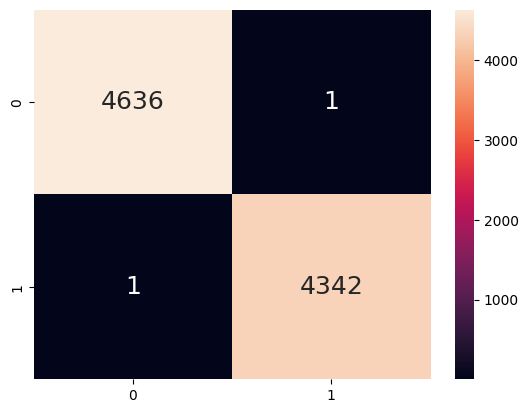

In [18]:
#evaluate on test data
trainer.evaluate()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f23536d-6e62-418a-b94b-ca9356b2599b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>